In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

import shap
import matplotlib.pyplot as plt

GLOBAL_SEED = 2025
np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# ===== 你的 MID 输出目录（截图里那一堆 npy/pt 的文件夹）=====
MID_OUT_DIR = Path("/root/Invertebrates_EC50_multi_fusion/mid_fusion_TGP")  # <-- 改成你实际路径

# ===== 你上传的理化数据集 =====
DATA_PATH = Path("/root/fusion_dataset/with_physchem_excels/Invertebrates_EC50_unique_physchem.xlsx")

# ===== 三端 embedding 路径（必须与训练中期融合时用的一致）=====
# Text: ChemBERTa CLS embedding（行号与 df 对齐）
TEXT_EMB_PATH = Path("/root/Invertebrates_EC50_multi_fusion/SMILES/smiles_outputs/reg_smiles_cls_embeddings_all.npy")

# Graph: 图嵌入 + row_id 映射（必须能从 row_id 找到对应向量）
GRAPH_EMB_PATH   = Path("/root/Invertebrates_EC50_multi_fusion/graph/graph_outputs/reg_graph_embeddings.npy")
GRAPH_ROWID_PATH = Path("/root/Invertebrates_EC50_multi_fusion/graph/graph_outputs/row_id_graph_for_emb.npy")

# Phys-token: 你中期融合里作为第三个 token 用的 physchem-MLP embedding + row_id
PHY_TOKEN_EMB_PATH   = Path("/root/Invertebrates_EC50_multi_fusion/phychem/physchem_mlp_rf_v2/emb_physchem_mlp_all.npy")
PHY_TOKEN_ROWID_PATH = Path("/root/Invertebrates_EC50_multi_fusion/phychem/physchem_mlp_rf_v2/row_id_clean.npy")

# 输出图
FIG_DIR = MID_OUT_DIR / "shap_figs_one"
FIG_DIR.mkdir(parents=True, exist_ok=True)
print("FIG_DIR:", FIG_DIR)


device: cuda
FIG_DIR: /root/Invertebrates_EC50_multi_fusion/mid_fusion_TGP/shap_figs_one


In [2]:
df = pd.read_excel(DATA_PATH, engine="openpyxl").reset_index(drop=True)

# 目标：和你训练一致（你 MID_TGP 用 log10）
df["mgperL"] = pd.to_numeric(df["mgperL"], errors="coerce")
y_full = np.log10(df["mgperL"].values + 1e-12)

# 用于对齐：你 mid_fusion 目录里保存的 rowid_TGP.npy
rowid = np.load(MID_OUT_DIR / "rowid_TGP.npy").astype(int)
df_aligned = df.iloc[rowid].reset_index(drop=True)
y_all = y_full[rowid].astype(float)

# ===== physchem 原始描述符（你这个表里前缀非常规范）=====
phys_cols = [c for c in df_aligned.columns if c.startswith("DESC_") or c.startswith("KIER_") or c.startswith("ESTATE_")]
print("phys_cols:", len(phys_cols))

# ===== meta（按你表里存在的列自动加）=====
meta_num_cols = []
if "Duration_Value(hour)" in df_aligned.columns:
    meta_num_cols.append("Duration_Value(hour)")

meta_cat_cols = []
for c in ["Effect", "Endpoint", "Species Group"]:
    if c in df_aligned.columns:
        meta_cat_cols.append(c)

print("meta_num_cols:", meta_num_cols)
print("meta_cat_cols:", meta_cat_cols)

# 组（如果你要按 SMILES 分组做 CV，也能用；这里 SHAP 不强制需要）
SMILES_COL = "SMILES_Canonical_RDKit"
groups = df_aligned[SMILES_COL].astype(str).values if SMILES_COL in df_aligned.columns else None


phys_cols: 24
meta_num_cols: ['Duration_Value(hour)']
meta_cat_cols: ['Effect', 'Endpoint', 'Species Group']


In [3]:
# phys
X_phys_raw = df_aligned[phys_cols].copy()

# meta: numeric
X_meta_num = df_aligned[meta_num_cols].copy() if len(meta_num_cols) else pd.DataFrame(index=df_aligned.index)

# meta: categorical -> one-hot
if len(meta_cat_cols):
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    X_meta_cat = ohe.fit_transform(df_aligned[meta_cat_cols].astype(str))
    meta_cat_names = ohe.get_feature_names_out(meta_cat_cols).tolist()
    X_meta_cat_df = pd.DataFrame(X_meta_cat, columns=meta_cat_names)
else:
    X_meta_cat_df = pd.DataFrame(index=df_aligned.index)

X_physmeta_df = pd.concat(
    [X_phys_raw, X_meta_num.reset_index(drop=True), X_meta_cat_df.reset_index(drop=True)],
    axis=1
)

# 缺失填补（RF 不接受 NaN）
imp = SimpleImputer(strategy="median")
X_physmeta = imp.fit_transform(X_physmeta_df.values)
X_physmeta_df = pd.DataFrame(X_physmeta, columns=X_physmeta_df.columns)

print("X_physmeta_df:", X_physmeta_df.shape)


X_physmeta_df: (3103, 30)


In [4]:
# Text（默认行号与 df 对齐，所以直接用 rowid）
X_text_all = np.load(TEXT_EMB_PATH).astype(np.float32)
X_text = X_text_all[rowid]
print("X_text:", X_text.shape)

# Graph（需要 row_id 映射）
X_graph_raw = np.load(GRAPH_EMB_PATH).astype(np.float32)
rowid_graph = np.load(GRAPH_ROWID_PATH).astype(int)
map_graph = {rid: i for i, rid in enumerate(rowid_graph)}
X_graph = np.stack([X_graph_raw[map_graph[r]] for r in rowid], axis=0).astype(np.float32)
print("X_graph:", X_graph.shape)

# Phys-token（physchem MLP embedding + row_id）
X_phys_token_raw = np.load(PHY_TOKEN_EMB_PATH).astype(np.float32)
rowid_phys = np.load(PHY_TOKEN_ROWID_PATH).astype(int)
map_phys = {rid: i for i, rid in enumerate(rowid_phys)}
X_phys_token = np.stack([X_phys_token_raw[map_phys[r]] for r in rowid], axis=0).astype(np.float32)
print("X_phys_token:", X_phys_token.shape)

# sanity
assert len(X_text) == len(X_graph) == len(X_phys_token) == len(X_physmeta_df) == len(y_all)


X_text: (3103, 768)
X_graph: (3103, 256)
X_phys_token: (3103, 64)


In [5]:
class TriCrossAttnBackbone(nn.Module):
    """
    只用于提取 attn_out（token-level 输出）
    不包含 mlp head，所以不会被 checkpoint 的 mlp 结构差异卡住
    """
    def __init__(self, dim_text, dim_graph, dim_phys, hidden_dim=256, num_heads=4, dropout=0.1):
        super().__init__()
        self.text_proj  = nn.Linear(dim_text,  hidden_dim)
        self.graph_proj = nn.Linear(dim_graph, hidden_dim)
        self.phys_proj  = nn.Linear(dim_phys,  hidden_dim)

        self.attn = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=False
        )

    def forward_tokens(self, x_text, x_graph, x_phys):
        t = self.text_proj(x_text)   # (B,H)
        g = self.graph_proj(x_graph) # (B,H)
        p = self.phys_proj(x_phys)   # (B,H)
        tokens = torch.stack([t, g, p], dim=0)  # (3,B,H)
        attn_out, attn_w = self.attn(tokens, tokens, tokens, need_weights=True, average_attn_weights=True)
        return attn_out  # (3,B,H)


dim_text = X_text.shape[1]
dim_graph = X_graph.shape[1]
dim_phys = X_phys_token.shape[1]

# ⚠️ hidden_dim / num_heads 必须与你训练时一致
# 如果你训练时不是 256/4，把 MID_TGP 里对应超参改过来
HIDDEN_DIM = 256
NUM_HEADS  = 4
DROPOUT    = 0.1

backbone = TriCrossAttnBackbone(dim_text, dim_graph, dim_phys,
                                hidden_dim=HIDDEN_DIM, num_heads=NUM_HEADS, dropout=DROPOUT).to(device)

state_path = Path("/root/Invertebrates_EC50_multi_fusion/mid_fusion_TGP/tricrossattn_TGP_state_dict.pt")

# 安全加载：weights_only=True（新版本 torch 推荐）
sd = torch.load(state_path, map_location="cpu", weights_only=True)

# 只保留 backbone 里存在的 key（自动丢弃 mlp.* 等无关参数）
sd_backbone = {k: v for k, v in sd.items() if k.startswith(("text_proj.", "graph_proj.", "phys_proj.", "attn."))}

missing, unexpected = backbone.load_state_dict(sd_backbone, strict=False)
print("✅ loaded backbone weights")
print("missing keys:", missing)
print("unexpected keys:", unexpected)

backbone.eval()


✅ loaded backbone weights
missing keys: []
unexpected keys: []


TriCrossAttnBackbone(
  (text_proj): Linear(in_features=768, out_features=256, bias=True)
  (graph_proj): Linear(in_features=256, out_features=256, bias=True)
  (phys_proj): Linear(in_features=64, out_features=256, bias=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
)

In [6]:
@torch.no_grad()
def extract_text_graph_tokens(backbone, X_text_np, X_graph_np, X_phys_np, batch_size=256):
    text_outs, graph_outs = [], []
    N = X_text_np.shape[0]
    for s in range(0, N, batch_size):
        e = min(N, s + batch_size)
        xt = torch.from_numpy(X_text_np[s:e]).float().to(device)
        xg = torch.from_numpy(X_graph_np[s:e]).float().to(device)
        xp = torch.from_numpy(X_phys_np[s:e]).float().to(device)

        attn_out = backbone.forward_tokens(xt, xg, xp)  # (3,B,H)
        text_outs.append(attn_out[0].detach().cpu().numpy())
        graph_outs.append(attn_out[1].detach().cpu().numpy())

    return np.concatenate(text_outs, axis=0), np.concatenate(graph_outs, axis=0)

text_tok_out, graph_tok_out = extract_text_graph_tokens(backbone, X_text, X_graph, X_phys_token, batch_size=256)

print("text_tok_out:", text_tok_out.shape)
print("graph_tok_out:", graph_tok_out.shape)


text_tok_out: (3103, 256)
graph_tok_out: (3103, 256)


In [7]:
# 用你 mid 目录保存的 train/val 划分（保持一致）
train_idx = np.load(MID_OUT_DIR / "train_idx_ca.npy").astype(int)
val_idx   = np.load(MID_OUT_DIR / "val_idx_ca.npy").astype(int)

dT = text_tok_out.shape[1]
dG = graph_tok_out.shape[1]

text_names  = [f"TEXT_{i:03d}" for i in range(dT)]
graph_names = [f"GRAPH_{i:03d}" for i in range(dG)]
phys_names  = list(X_physmeta_df.columns)

X_all = np.hstack([text_tok_out, graph_tok_out, X_physmeta_df.values])
feature_names = text_names + graph_names + phys_names
X_all_df = pd.DataFrame(X_all, columns=feature_names)

X_train = X_all_df.iloc[train_idx].reset_index(drop=True)
y_train = y_all[train_idx]

# 训练 RF（你也可以换成你 mid pipeline 的 best_params）
rf = RandomForestRegressor(
    n_estimators=291,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=GLOBAL_SEED
)
rf.fit(X_train, y_train)
print("RF fit done. Train R2:", rf.score(X_train, y_train))

# SHAP（抽样更快）
X_show = X_train.sample(n=min(2000, len(X_train)), random_state=GLOBAL_SEED)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_show)  # (n_show, n_features)

# 三组索引
idx_text  = np.arange(0, dT)
idx_graph = np.arange(dT, dT + dG)
idx_phys  = np.arange(dT + dG, dT + dG + len(phys_names))

print("shap_values:", shap_values.shape)


RF fit done. Train R2: 0.9385967863440712
shap_values: (2000, 542)


In [8]:
import numpy as np
import pandas as pd

# ---- 0) 检查必需变量 ----
need = ["shap_values", "X_show", "idx_text", "idx_graph", "idx_phys"]
for v in need:
    assert v in globals(), f"缺少变量：{v}（先跑 SHAP 那个 cell）"

# ---- 1) 取出 X_show 的 numpy 形式 + 列名 ----
if isinstance(X_show, pd.DataFrame):
    X_show_np = X_show.values
    colnames = list(X_show.columns)
else:
    X_show_np = np.asarray(X_show)
    # 如果没有列名，就临时造一个（后面 phys 名也能用）
    colnames = [f"f{i}" for i in range(X_show_np.shape[1])]

# ---- 2) 计算 block-level SHAP：Text/Graph 聚合 + Phys 细分 ----
shap_text_block  = shap_values[:, idx_text].sum(axis=1)    # (n,)
shap_graph_block = shap_values[:, idx_graph].sum(axis=1)   # (n,)
shap_phys        = shap_values[:, idx_phys]                # (n, d_phys)

shap_mixed = np.column_stack([shap_text_block, shap_graph_block, shap_phys])

# ---- 3) 构造用于着色的 feature matrix：Text/Graph 用 L2 norm + Phys 原值 ----
text_norm  = np.linalg.norm(X_show_np[:, idx_text], axis=1)
graph_norm = np.linalg.norm(X_show_np[:, idx_graph], axis=1)
X_phys_np  = X_show_np[:, idx_phys]

X_mixed_np = np.column_stack([text_norm, graph_norm, X_phys_np])

# ---- 4) feature_names（用于 y 轴标签）----
phys_names = [colnames[i] for i in idx_phys]
feature_names = ["Graph(block)", "Text(block)"]  # 你想 Graph 在上就这样；想反过来就交换顺序
# 注意：上面 shap_mixed 的列顺序是 [Text, Graph, Phys]，所以这里要保持一致
feature_names = ["Text(block)", "Graph(block)"] + phys_names

print("✅ built shap_mixed:", shap_mixed.shape)
print("✅ built X_mixed_np:", X_mixed_np.shape)
print("✅ built feature_names:", len(feature_names))


✅ built shap_mixed: (2000, 32)
✅ built X_mixed_np: (2000, 32)
✅ built feature_names: 32


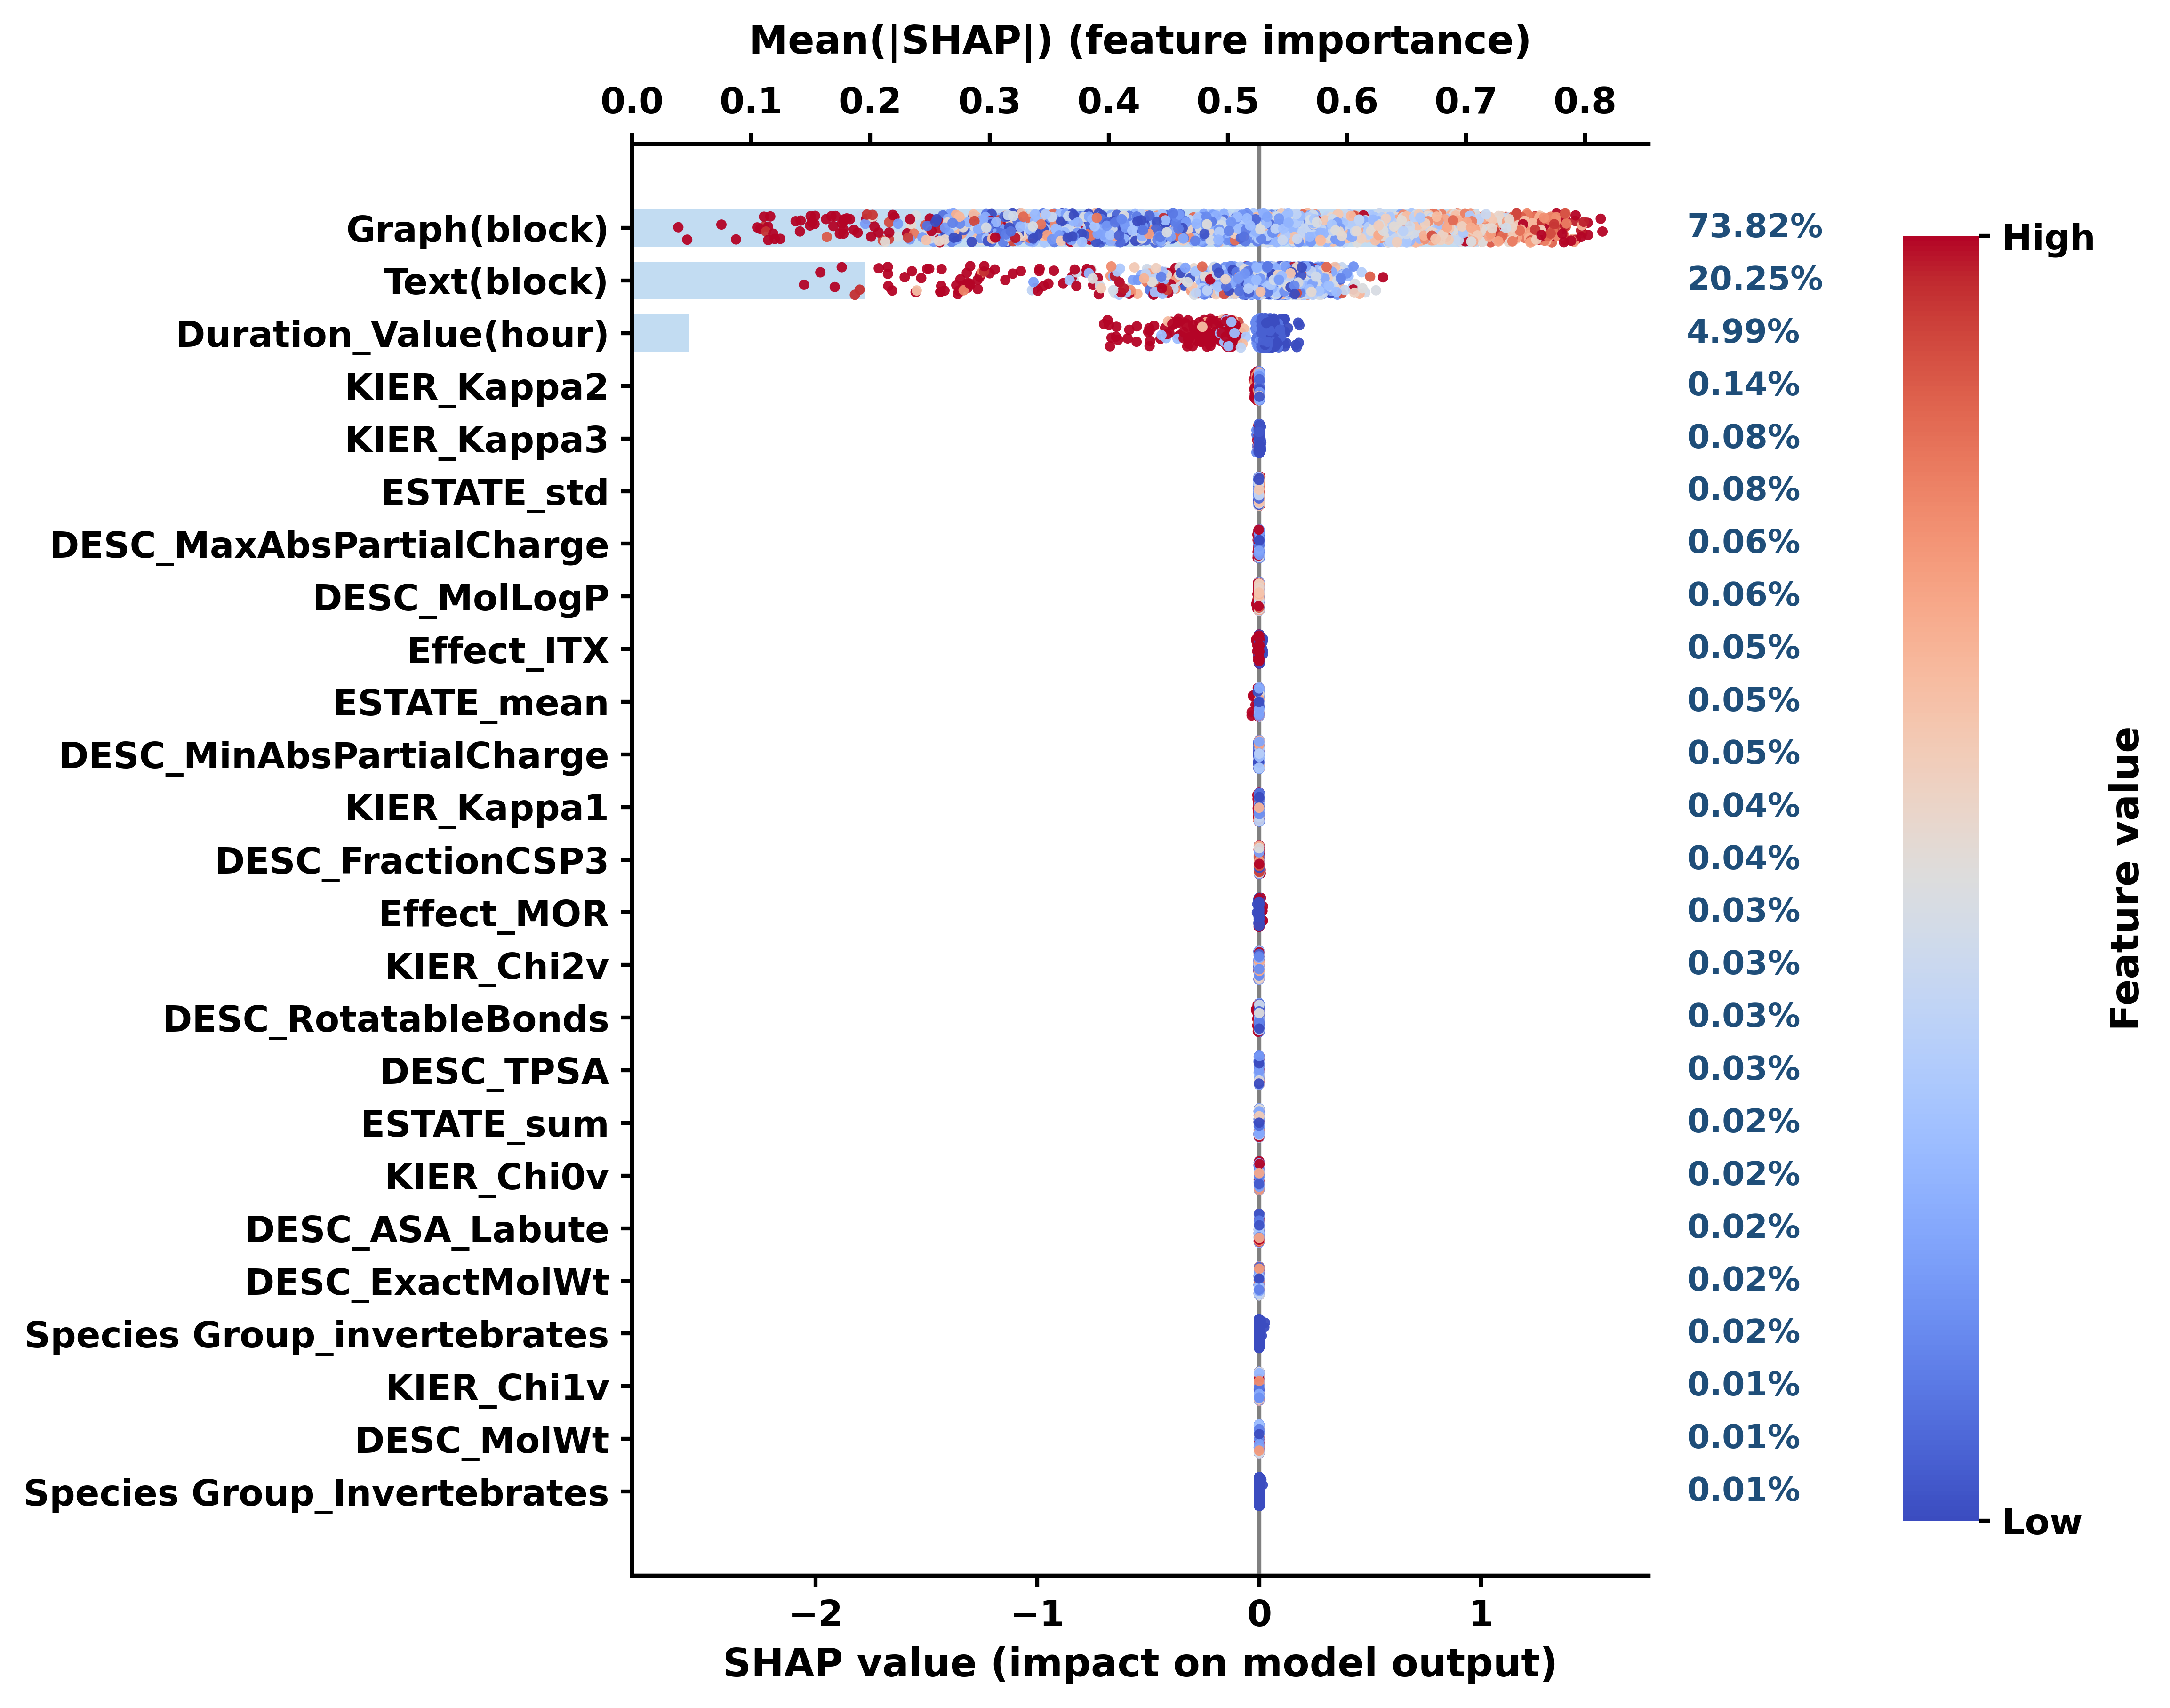

✅ saved: /root/Invertebrates_EC50_multi_fusion/mid_fusion_TGP/shap_figs_one/shap_summary_bar_beeswarm_final.svg


In [9]:
# ===== SHAP 自绘 summary：bar(Mean|SHAP|) + beeswarm + pct列 + 外置色条
# ===== 导出 SVG + 字体转路径（防缺字体替换）+ 全部加粗 =====

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# =========================
# 0) 全局风格：加粗 + SVG 字体转路径
# =========================
mpl.rcParams.update({
    "font.size": 12,
    "font.weight": "bold",
    "axes.labelsize": 12,
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "xtick.major.width": 1.2,
    "ytick.major.width": 1.2,
    "axes.linewidth": 1.2,

    # 关键：SVG 中把文字转成路径（避免对方缺字体导致替换）
    "svg.fonttype": "path",
    "svg.hashsalt": "fusion",
})

# =========================
# 1) 输入检查
# =========================
assert shap_mixed.shape[0] == X_mixed_np.shape[0], "rows mismatch"
assert shap_mixed.shape[1] == X_mixed_np.shape[1] == len(feature_names), "cols mismatch"

# =========================
# 2) 重要性排序（Top-K）
# =========================
mean_abs = np.abs(shap_mixed).mean(axis=0)
order = np.argsort(mean_abs)[::-1]
K = min(25, shap_mixed.shape[1])
order = order[:K]

sv = shap_mixed[:, order]
fv = X_mixed_np[:, order]
names = [feature_names[i] for i in order]
mean_abs_k = mean_abs[order]
pct_k = mean_abs_k / (mean_abs.sum() + 1e-12) * 100

# =========================
# 3) 画布（手动布局）
# =========================
fig, ax = plt.subplots(figsize=(10.8, 7.8), dpi=500, constrained_layout=False)
fig.subplots_adjust(left=0.30, right=0.70, top=0.90, bottom=0.12)

# 顶部 bar axis
ax_bar = ax.twiny()
ax_bar.barh(
    np.arange(K),
    mean_abs_k,
    height=0.72,
    color="#bcd9f1",
    alpha=0.9,
    zorder=0
)
ax_bar.set_xlim(0, mean_abs_k.max() * 1.20)
ax_bar.set_xlabel("Mean(|SHAP|) (feature importance)", labelpad=10, fontweight="bold")

# bar 背景
ax.set_zorder(2)
ax.patch.set_alpha(0)

# =========================
# 4) beeswarm
# =========================
cmap = mpl.cm.coolwarm
rng = np.random.default_rng(2025)
jitter = (rng.random(sv.shape) - 0.5) * 0.55

def robust_norm(x):
    lo = np.nanpercentile(x, 5)
    hi = np.nanpercentile(x, 95)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return np.zeros_like(x)
    x = np.clip(x, lo, hi)
    return (x - lo) / (hi - lo)

for j in range(K):
    x = sv[:, j]
    y = j + jitter[:, j]
    c = robust_norm(fv[:, j])
    ax.scatter(
        x, y,
        s=10,
        c=c,
        cmap=cmap,
        alpha=0.95,
        linewidths=0,
        zorder=3,
        # 如果点特别多导致 SVG 很大，可以打开这一句（散点栅格化，轴/字仍是矢量）
        # rasterized=True
    )

# =========================
# 5) 主轴样式（强制显示 y 标签 + 加粗）
# =========================
ax.axvline(0, color="gray", lw=1.2)
ax.set_yticks(np.arange(K))
ax.set_yticklabels(names, fontsize=11, fontweight="bold")
ax.tick_params(axis="y", labelleft=True)
ax.invert_yaxis()
ax.set_xlabel("SHAP value (impact on model output)", fontweight="bold")

# 刻度加粗
for t in ax.get_xticklabels():
    t.set_fontweight("bold")
for t in ax_bar.get_xticklabels():
    t.set_fontweight("bold")

# 去掉右侧框线
ax.spines["right"].set_visible(False)
ax_bar.spines["right"].set_visible(False)

# =========================
# 6) 百分比列（单独轴，不 sharey）
# =========================
ax_pct = fig.add_axes([0.715, 0.12, 0.07, 0.78])  # [left,bottom,width,height]
ax_pct.set_xlim(0, 1)
ax_pct.set_ylim(ax.get_ylim())
ax_pct.set_xticks([])
ax_pct.set_yticks([])
for sp in ax_pct.spines.values():
    sp.set_visible(False)

for j in range(K):
    ax_pct.text(
        0.0, j,
        f"{pct_k[j]:.2f}%",
        va="center", ha="left",
        fontsize=10,
        color="#1f4e79",
        fontweight="bold"
    )

# =========================
# 7) 色条：完全在主框外 + 加粗
# =========================
mappable = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 1), cmap=cmap)

cax = fig.add_axes([0.80, 0.15, 0.03, 0.70])
cbar = fig.colorbar(mappable, cax=cax)
cbar.set_label("Feature value", fontweight="bold")
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Low", "High"])
for t in cbar.ax.get_yticklabels():
    t.set_fontweight("bold")
cbar.outline.set_visible(False)

# =========================
# 8) SVG 输出（文字已转路径）
# =========================
FIG_DIR = Path(FIG_DIR)  # 兼容你前面 FIG_DIR 可能是 str
FIG_DIR.mkdir(parents=True, exist_ok=True)

out_path = FIG_DIR / "shap_summary_bar_beeswarm_final.svg"
plt.savefig(out_path, format="svg", bbox_inches="tight")
plt.show()

print("✅ saved:", out_path)
